In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import casacore
import casacore.tables as pt
import pandas as pd
from sklearn import cluster
from sklearn import metrics
plt.rcParams['figure.figsize']=[10,8]
plt.rcParams['font.size']=14
date='20170804'
#fname = "/data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB052_uv_autoweight.MS"
basedir='/data/LOFAR/'+date+'/'
fname = basedir+"L602826_SAP000_SB154_uv_autoweight.MS"
savedir=basedir+'viscutoff/'

In [2]:
#Get the data from the MS for only the core station baselines
run=False
if run is True:
    ant = pt.table(fname+"/ANTENNA").getcol("NAME")
    cs = [i for i,j in enumerate(ant) if "CS" in j] #Select Core stations only

In [3]:

run=False
if run is True:
    #Develop pandas dataframes for each cross-correlation before and after calibration
    #They hold the visibility amplitudes and phases for all LOFAR baselines over all timesteps of observation.
    #blines = []
    #ONLY FOR XX
    dfxx = pd.DataFrame()
    cdfxx = pd.DataFrame()
    fdfxx = pd.DataFrame()
    dfxx_test = pd.DataFrame()
    for idx1,ant1 in enumerate(cs):
        for ant2 in cs[idx1+1:]:
            column=ant[ant1]+"_"+ant[ant2]
            #blines.append(column)
            myt = pt.taql("select from $fname where ANTENNA1==$ant1 and ANTENNA2==$ant2")
            flags = myt.getcol("FLAG")
            datacol = myt.getcol("DATA")
            corrected_datacol = myt.getcol("CORRECTED_DATA")
            uvw=myt.getcol("UVW")
            fdfxx[column]=flags[:,0,0]
            #cdfxx[column]=np.abs(np.ma.array(corrected_datacol[:,0,0], mask=flags[:,0,0])).astype(np.float32)
            #dfxx[column]=np.abs(np.ma.array(datacol[:,0,0], mask=flags[:,0,0])).astype(np.float32)
            dfxx_test[column+'_data_real']=np.ma.array(datacol[:,0,0].real, mask=flags[:,0,0])
            dfxx_test[column+'_data_imag']=np.ma.array(datacol[:,0,0].imag, mask=flags[:,0,0])
            #dfxx_test[column+'_data_angle']=np.angle(np.ma.array(datacol[:,0,0].imag, mask=flags[:,0,0]))          
            dfxx_test[column+'_corrdata_real']=np.ma.array(corrected_datacol[:,0,0].real, mask=flags[:,0,0])
            dfxx_test[column+'_corrdata_imag']=np.ma.array(corrected_datacol[:,0,0].imag, mask=flags[:,0,0])
            #dfxx_test[column+'_corrdata_angle']=np.angle(np.ma.array(corrected_datacol[:,0,0].imag, mask=flags[:,0,0]))
            dfxx_test[column+'_u']=np.ma.array(uvw[:,0], mask=flags[:,0,0])
            dfxx_test[column+'_v']=np.ma.array(uvw[:,1], mask=flags[:,0,0])
            dfxx_test[column+'_w']=np.ma.array(uvw[:,2], mask=flags[:,0,0])
    #Flag column dataframes
    fdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_fxx.p')
    #Data column dataframes
    #dfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxx.p')
    #Corrected data column dataframes
    #cdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
    dfxx_test.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxx_test.p')

In [4]:
run=True
if run is True:
    dfxx_test=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_dxx_test.p')

In [5]:
#Define the columns in the dataframe that represent different quantities.
#U,V,W coordinates
cols_v=[col for col in dfxx_test.columns if '_v' in col]
cols_u=[col for col in dfxx_test.columns if '_u' in col]
cols_w=[col for col in dfxx_test.columns if '_w' in col]
#The magnitude of the UVW distances - units?
dr=np.sqrt(dfxx_test[cols_v].values[0]*dfxx_test[cols_v].values[0]+
           dfxx_test[cols_u].values[0]*dfxx_test[cols_u].values[0]+
           dfxx_test[cols_w].values[0]*dfxx_test[cols_w].values[0])
#The corrected real and imaginary parts of the visibilities - units?
cols_cdr=[col for col in dfxx_test.columns if '_corrdata_real' in col]
cols_cdi=[col for col in dfxx_test.columns if '_corrdata_imag' in col]
#The non-corrected real and imaginary parts of the visibilities
cols_dr=[col for col in dfxx_test.columns if '_data_real' in col]
cols_di=[col for col in dfxx_test.columns if '_data_imag' in col]

In [6]:
#Calculate the amplitudes and phases of the corrected visibilities
phases=pd.DataFrame()
amplitudes=pd.DataFrame()
phasecols=[]
ampcols=[]
#len(cols_cdr)
for ii in range(len(cols_cdr)):
    phasecol='_'.join(cols_cdr[ii].split('_')[0:2])+'_phase'
    ampcol='_'.join(cols_cdr[ii].split('_')[0:2])+'_amp'
    phasecols.append(phasecol)
    ampcols.append(ampcol)
    
    #Pair the real and imaginary
    numlist=np.array(list(zip(dfxx_test[cols_cdr[ii]].values,dfxx_test[cols_cdi[ii]].values)))
    #Convert to complex numbers
    compnums=[complex(num[0],num[1]) for num in numlist]
    #First, the amplitude
    amplitudes[ampcol]=[np.abs(compnum) for compnum in compnums]
    #Second, the phase
    phases[phasecol]=[np.angle(compnum) for compnum in compnums]

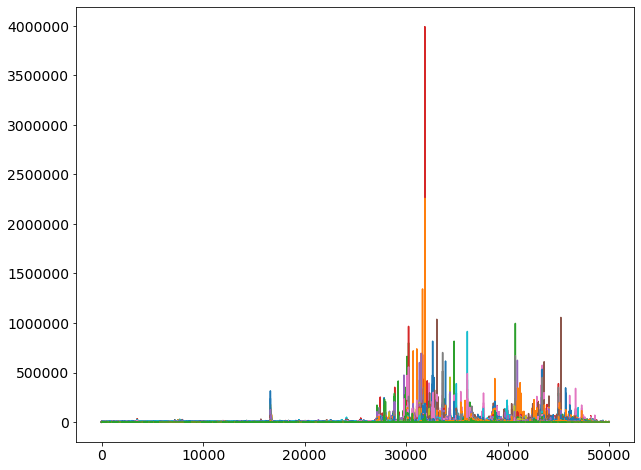

In [170]:
#Plot all the amplitudes
#for ii in range(len(cols_cdr)): plt.plot(np.abs(dfxx_test[cols_cdr[ii]].values[0:50000]))
fig=plt.figure(figsize=(15,7))

#Plot the magnitude of the XX observations
ax1 = fig.add_subplot(121)
for ampcol in ampcols: plt.plot(amplitudes[ampcol].values[0:50000])
    


In [7]:
myt = pt.taql("select from $fname where (ANTENNA1 < 23) and (ANTENNA2 < 23) and (ANTENNA1 != ANTENNA2)")
flags = myt.getcol("FLAG")

In [8]:
myt
#flags.shape

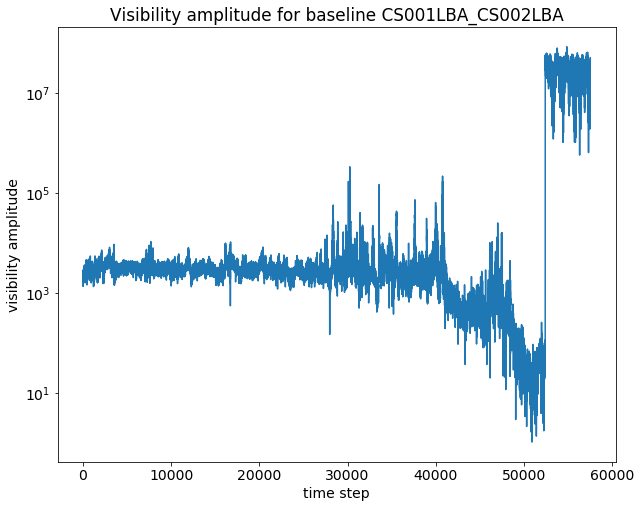

In [199]:
#Quick plot of the XX Visibility amplitudes
plt.plot(amplitudes['CS001LBA_CS002LBA'+'_amp']) # different colors is different polarisations (XX,XY,YX,YY)
plt.title('Visibility amplitude for baseline '+cdfxx.columns[0])
plt.xlabel("time step")
plt.ylabel("visibility amplitude")
plt.yscale('log')
plt.show()

Text(0, 0.5, 'Phase, deg')

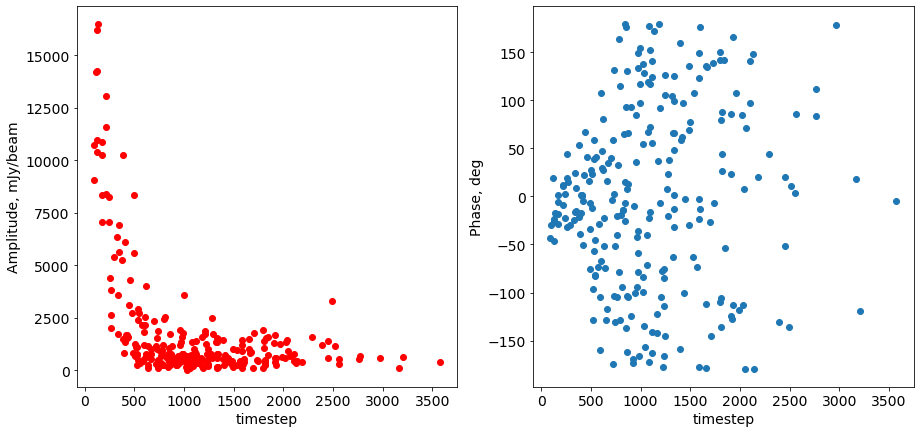

In [194]:
#Plot the amplitude and phase of the visibilities for a single timestep
timeind=30000
fig=plt.figure(figsize=(15,7))

#Plot the magnitude of the XX observations
ax1 = fig.add_subplot(121)
#plt.title('Instantaneous LOFAR visibilities for 253 baselines')
ax1.set_xlabel('baseline, lambda')
ax1.set_ylabel('Amplitude, mJy/beam')
ax1.scatter(dr,amplitudes.loc[timeind].values,marker='o',color='red')
#Plot the phase angle of the XX observations
ax2 = fig.add_subplot(122)
ax2.scatter(dr,phases.loc[timeind].values*180./np.pi,marker='o')
ax2.set_xlabel('timestep')
ax2.set_ylabel('Phase, deg')

Text(0, 0.5, 'Phase, deg')

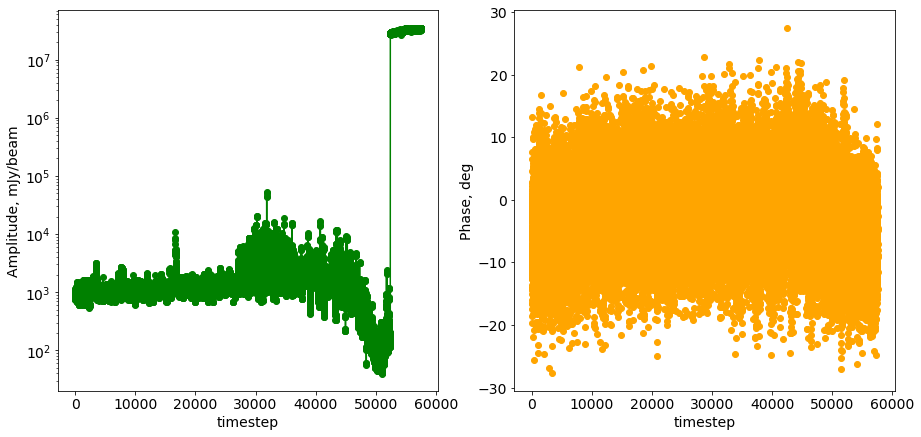

In [11]:
#Plot the mean amplitude and phase of the visibilities for all timesteps
ampmean=amplitudes.mean(axis=1).values
phasemean=phases.mean(axis=1).values
fig=plt.figure(figsize=(15,7))
#plt.title('Mean Visibility Amplitudes and Phases')
#Plot the mean amplitudes of the XX observations
ax1 = fig.add_subplot(121)
ax1.plot(range(len(ampmean)),ampmean,marker='o',color='green')
#ax1.set_ylim(0,4.e4)
ax1.set_yscale('log')
ax1.set_xlabel('timestep')
ax1.set_ylabel('Amplitude, mJy/beam')
ax1.set_title('Mean XX Visibility Amplitude')
#Plot the phase angle of the XX observations
ax2 = fig.add_subplot(122)
ax2.scatter(range(len(phasemean)),phasemean*180./np.pi,marker='o',color='orange')
#ax2.set_ylim(-180,180)
ax2.set_xlabel('timestep')
ax2.set_ylabel('Phase, deg')


(57520, 253)

In [27]:
### Loop over all intervals/timesteps, and do K-Means clustering over all baselines
#The code below only does it for the magnitudes of the XX correlations
cdfxx=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
vmax=[]
for tt in range(ntimes):
    data = np.abs(cdfxx.loc[tt].values.reshape(-1, 1)).astype(np.float32)
    kmeans=cluster.KMeans(n_clusters=5)
    model=kmeans.fit(data)
    # Get cluster assignment labels
    labels = kmeans.labels_
    # Format results as a DataFrame
    #results = pd.DataFrame([labels]).T
    #u_labels = np.unique(results[1].values)
    cluster_centers = kmeans.cluster_centers_
    u_labels=cluster_centers[:,0].argsort()
    #Metrics scores
    #sscore=metrics.silhouette_score(data, labels, metric = 'euclidean')
    #chscore=metrics.calinski_harabasz_score(data, labels)
    #Record the cut-offs
    vmax.append(np.nanmax(data[labels == u_labels[1]]))
vdf=pd.DataFrame(vmax)
vdf.to_pickle(savedir+'visibility_cutoff_xx.p')

NameError: name 'ntimes' is not defined

In [94]:
#UPDATE THE FLAG TABLE OF THE MS DATA BASED ON THE VIS MAGNITUDE CUT-OFFS - ONLY FOR XX correlation

#Set this to True to do the update
update_MS_flags = False

if update_MS_flags:
    vmax=pd.read_pickle(savedir+'visibility_cutoff_xx.p')
    ntimes=vmax.shape[0]
    
    # to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
    myt = pt.table(fname,readonly=False)
    flags = myt.getcol("FLAG")
    desc=myt.getcoldesc("FLAG")
    cdata = myt.getcol("CORRECTED_DATA")
    
    newflags=flags.copy()
    stride=630 #the number of antenna station combinations in this MS
    #Apply time-dependent cut-off flagging
    for tt in range(ntimes):
        newflags[tt*stride:(tt+1)*stride,0,0] = np.abs(cdata[tt*stride:(tt+1)*stride,0,0]) > vmax.values[tt][0]
    newflags = np.logical_or(flags,newflags)
    if "OLDFLAGS" in myt.colnames():
        print ("column OLDFLAGS already existing, not overwriting")
    else:
       desc['name']="OLDFLAGS"
       myt.addcols(desc)
       myt.putcol("OLDFLAGS",flags)
       myt.putcol("FLAG",newflags)
    myt.close()

Successful read/write open of default-locked table /data/L602826_SAP000_SB154_uv_autoweight_test.MS: 27 columns, 36237600 rows


<ipython-input-168-de7a0f164705>:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('./visibility_amplitudes.png',bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


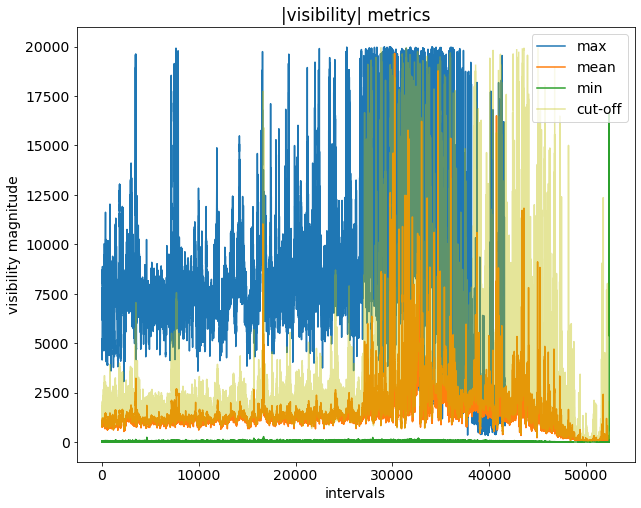

In [168]:
#Plot the |Vis| minimum,mean,maximum, and cut-offs - ONLY FOR XX
vmax=pd.read_pickle(savedir+'/visibility_cutoff_xx.p')
cdfxx=np.abs(pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')).astype(np.float32)
origmax=cdfxx.max(axis=1).values
origmean=cdfxx.mean(axis=1).values
origmin=cdfxx.min(axis=1).values
plt.figure(figsize=[10,8])
plt.plot(origmax[origmax < 2.e4],label='max')
plt.plot(origmean[origmean < 2.e4],label='mean')
plt.plot(origmin[origmin < 2.e4],label='min')
plt.plot(vmax[vmax < 2.e4],label='cut-off',alpha=0.5,c='y')
plt.xlabel('intervals')
plt.ylabel('visibility magnitude')
plt.title('|visibility| metrics')
plt.legend()
plt.savefig(savedir+'visibility_amplitudes_XX.png',bbox_inches='tight')

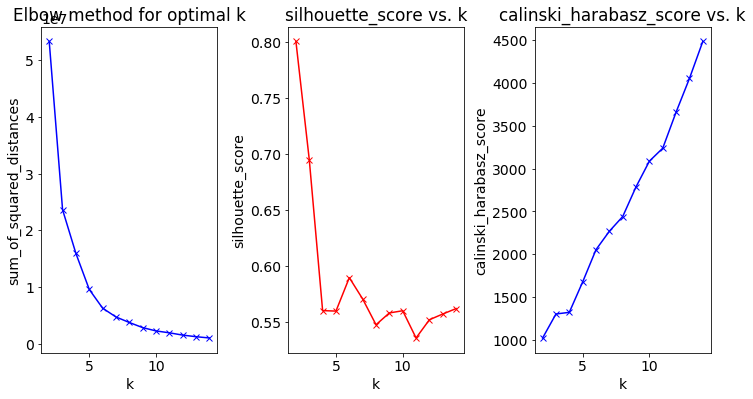

In [173]:
#Recording the metrics for a variety of k-values for comparison - ONLY FOR XX
#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
cdfxx=np.abs(pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')).astype(np.float32)
#Do this for a single timestep. The first one is selected here.
tt=0
data = cdfxx.loc[tt].values.reshape(-1, 1)

sum_of_squared_distances = []
chscore = []
sscore = []
K = range(2,15)
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    model = kmeans.fit(data)
    labels = kmeans.labels_
    sum_of_squared_distances.append(kmeans.inertia_)
    sscore.append(metrics.silhouette_score(data, labels, metric = 'euclidean'))
    chscore.append(metrics.calinski_harabasz_score(data, labels))

    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
plt.subplot(131)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.subplot(132)
plt.plot(K, sscore, 'rx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score vs. k')
plt.subplot(133)
plt.plot(K, chscore, 'bx-')
plt.xlabel('k')
plt.ylabel('calinski_harabasz_score')
plt.title('calinski_harabasz_score vs. k')
fig.subplots_adjust(wspace=.4)
plt.savefig(savedir+'k_value_comparisons.png',bbox_inches='tight')
plt.show()

253


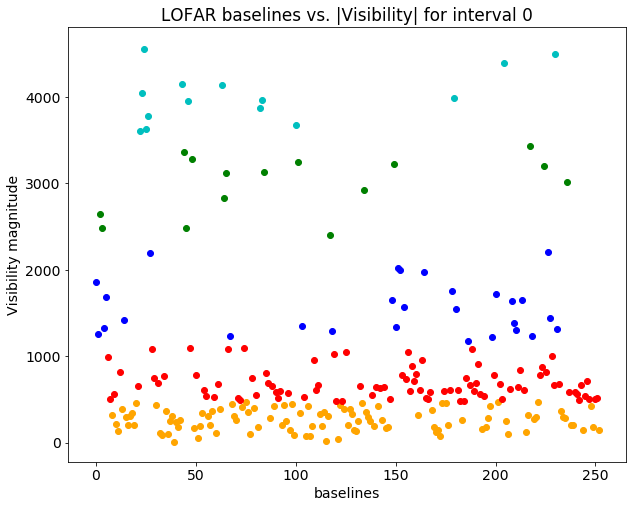

In [172]:
#PLOT THE CLUSTER FOR A SINGLE TIMESTEP
cdfxx=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
#Do this for a single timestep. The first one is selected here.
tt=0
data = cdfxx.loc[tt].values.reshape(-1, 1)
nbaselines=data.shape[0]
print(nbaselines)
baselines=np.arange(nbaselines)
colors=['r','g','b','orange','c']
kmeans = cluster.KMeans(n_clusters=5)
kmeans.fit(data)
labels = kmeans.labels_

cluster_centers = kmeans.cluster_centers_
u_labels=cluster_centers[:,0].argsort()
for u_label in u_labels:
    plt.scatter(baselines[labels == u_label],data[labels == u_label],c=colors[u_label])
plt.xlabel('baselines')
plt.ylabel('Visibility magnitude')
plt.title('LOFAR baselines vs. |Visibility| for interval {}'.format(tt))
plt.savefig(savedir+'baselines_visibility_clusters.png',bbox_inches='tight')